# Import libs

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.nn import ModuleList
from torch import nn
import torch.optim as optim

# custom libs
from libs.PretrainedModels import AlexNet_cc, SqueezeNet_cc, InceptionV3_cc, ResNet18_cc
from libs.utils import get_model_name, import_dataset, reverse_norm, init_model
from libs.Dataset import dst

In [2]:
random.seed(1996)
np.random.seed(1996)

In [3]:
# parameters for dataloaders
batch_size=32
num_workers=2
drop_last=True

In [4]:
dst.create_data_loader(batch_size=batch_size, num_workers=num_workers, drop_last=drop_last)

### Visualize dataset

Training

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


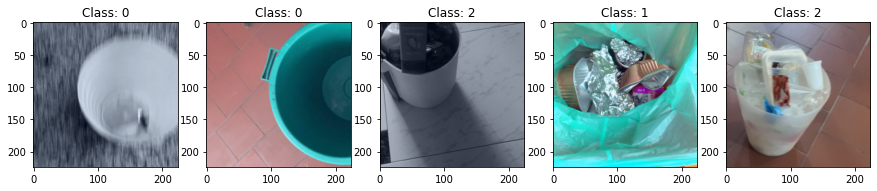

In [7]:
train_features, train_labels = next(iter(dst.training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst.training_loader))
plt.show()

Test

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


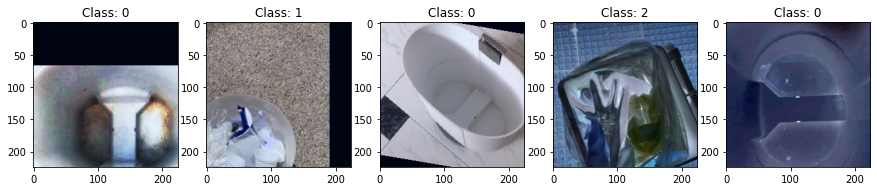

In [6]:
train_features, train_labels = next(iter(dst.test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst.test_loader))
plt.show()

## Dataset for inceptionv3 -- to move

In [6]:
dst_inceptionv3 = import_dataset(path_dst=path_dst, 
    train_transform=transforms.Compose([
        transforms.Resize(320),
        # using the same as the test because the trash bin is centered in the image
        transforms.CenterCrop(299), # good for inceptionv3?
        transforms.RandomApply(ModuleList([
            transforms.ColorJitter(brightness=.3, hue=.2),
        ]), p=0.3),

        transforms.RandomApply(ModuleList([
            transforms.Grayscale(num_output_channels=3),
        ]), p=0.2),

        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    test_transform=transforms.Compose([
        transforms.Resize(320), 
        transforms.CenterCrop(299), # good for inceptionv3?
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]), path_gdrive=path_gdrive)

dst_inceptionv3.create_data_loader(batch_size=batch_size, num_workers=num_workers, drop_last=drop_last)

### Visualize dataset

Training

Feature batch shape: torch.Size([32, 3, 299, 299])
Labels batch shape: torch.Size([32])


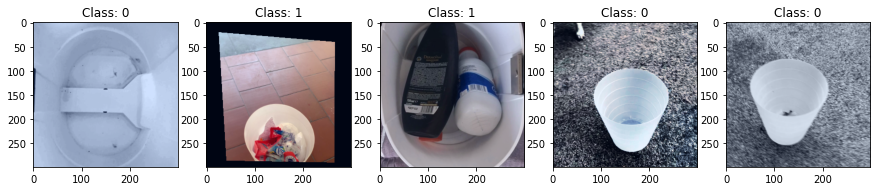

In [9]:
train_features, train_labels = next(iter(dst_inceptionv3.training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst_inceptionv3.training_loader))
plt.show()

Test

Feature batch shape: torch.Size([32, 3, 299, 299])
Labels batch shape: torch.Size([32])


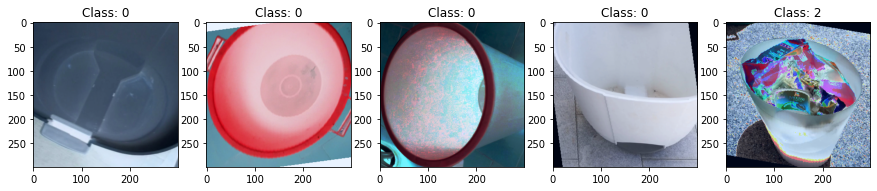

In [10]:
train_features, train_labels = next(iter(dst_inceptionv3.test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst_inceptionv3.test_loader))
plt.show()

# Find best LR

In [5]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()

In [6]:
## da sostituire le var sotto
optim_lr = 0.0001
momentum = 0.99
end_lr = 0.01
num_iter = 100

### Finding best lr for SqueezNet - DONE

In [8]:
squeezenet = init_model(creator=SqueezeNet_cc(), model_name='SqueezeNet', feature_extract=True, use_pretrained=True)
squeezenet = squeezenet.ret_model()

optimizer = optim.SGD(squeezenet.parameters(), lr=optim_lr, momentum=momentum)

Initializing: SqueezeNet


100%|██████████| 100/100 [3:11:31<00:00, 114.92s/it]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.10E-03


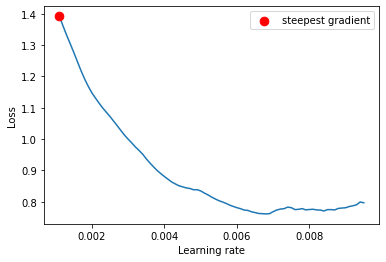

In [9]:
lr_finder = LRFinder(squeezenet, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

Suggested lr is `0.0011`

## Finding best lr for AlexNet

Initializing: AlexNet


 85%|████████▌ | 85/100 [1:27:33<15:27, 61.81s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.10E-03


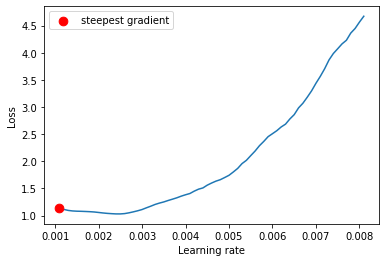

In [7]:
alexnet = init_model(creator=AlexNet_cc(), model_name='AlexNet', feature_extract=True, use_pretrained=True)
alexnet = alexnet.ret_model()

optimizer = optim.SGD(alexnet.parameters(), lr=optim_lr, momentum=momentum)

lr_finder = LRFinder(alexnet, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

Suggested lr is `0.0011`

## Finding best lr for ResNet

Initializing: ResNet


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/daniloleocata/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:26<00:00, 1.80MB/s]
100%|██████████| 100/100 [4:09:28<00:00, 149.69s/it]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.20E-03


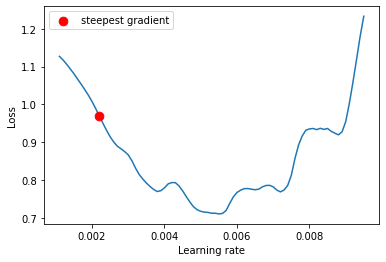

In [8]:
resnet = init_model(creator=ResNet18_cc(), model_name='ResNet', feature_extract=True, use_pretrained=True)
resnet = resnet.ret_model()

optimizer = optim.SGD(resnet.parameters(), lr=optim_lr, momentum=momentum)

lr_finder = LRFinder(resnet, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

lr suggested is `0.0022`